In [2]:
import cv2
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.externals import joblib
from operator import itemgetter
from time import time
import matplotlib.pyplot as plt
import glob
import pickle
import tabulate

import sklearn
%matplotlib inline

# Utils

In [3]:
def draw_boxes(img, bboxes, color = [0, 0, 255], thickness = 6):
    cl = color
    for (tl, br) in bboxes:
        if color == None:
            cl = (np.random.randint(0, 256), np.random.randint(0, 256), np.random.randint(0, 256))
        cv2.rectangle(img, tl, br, cl, thickness)

# Load Data

12


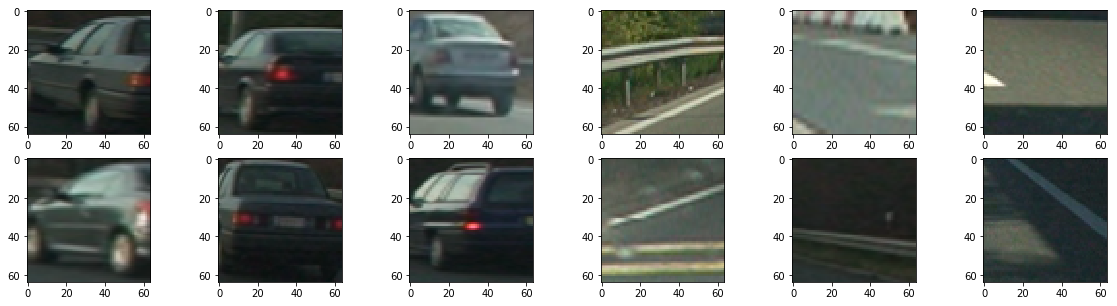

In [4]:
images = glob.glob('data/vehicles/**/*')[:6] + glob.glob('data/non-vehicles/**/*')[:6]
grid = (2, 6)
coors = np.vstack(np.mgrid[:grid[0], :grid[1]].T)
data = []
f = plt.figure(figsize = (20, 5))
for idx, iname in enumerate(images):
    img = cv2.imread(iname)
    axis = plt.subplot2grid(grid, coors[idx])
    img = img[:, :, ::-1]
    axis.imshow(img)
    data.append(img)

print(len(data))

# Feature Extraction

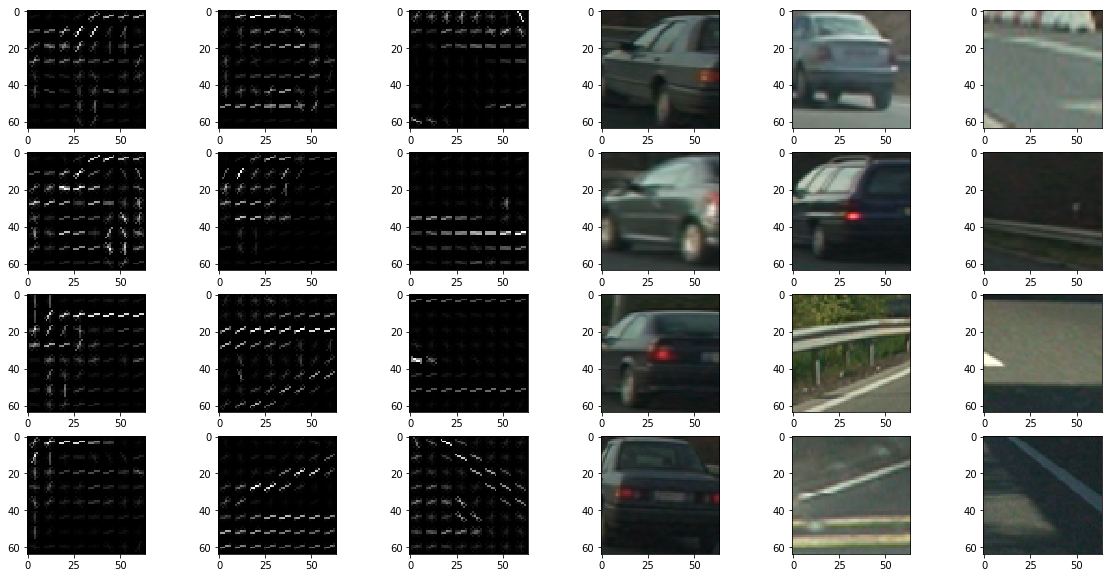

In [281]:
from skimage.feature import hog

orient = 9
pix_per_cell = 8
cell_per_block = 2

def extract_hog_features(img, cspace = None, orient = orient, pix_per_cell = pix_per_cell, 
                     cell_per_block = cell_per_block, feature_vec = True, debug = False):
    hog_image = None
    img = np.copy(img)
    if cspace != None:
        img = cv2.cvtColor(img, cspace)
    
    features = []
    visual = []
    for channel in range(img.shape[-1]):
        if debug:
            hog_features, hog_image = hog(
                img[:, :, channel], 
                orientations = orient, 
                pixels_per_cell = (pix_per_cell, pix_per_cell), 
                cells_per_block = (cell_per_block, cell_per_block),
                visualise = True,
                feature_vector = feature_vec,
                transform_sqrt = False,
                block_norm = 'L2-Hys'
            )
        else:
            hog_features = hog(
                img[:, :, channel], 
                orientations = orient, 
                pixels_per_cell = (pix_per_cell, pix_per_cell), 
                cells_per_block = (cell_per_block, cell_per_block),
                visualise = False,
                feature_vector = feature_vec,
                transform_sqrt = False,
                block_norm = 'L2-Hys'
            )
        features.append(hog_features)
        visual.append(hog_image)

    if feature_vec:
        return np.ravel(features), np.dstack(visual)
    else:
        return features, np.dstack(visual)
    
def extract_color_features(img, size = (32, 32)):
    features = []
    for channel in range(img.shape[-1]):
        ch_feature = cv2.resize(img[:, :, channel], size).ravel()
        features.append(ch_feature)
    return np.array(features)

def extract_hist_features(img, nbins = 32, ranges = (0, 256)):
    features = []
    for channel in range(img.shape[-1]):
        features.append(cv2.calcHist(img, [channel], None, (nbins, ), ranges))
    return np.array(features)

def extract_features(img, cspace = None, orient = orient, pix_per_cell = pix_per_cell, 
                     cell_per_block = cell_per_block, spatial_bin = (32, 32), nbins = 32, ranges = (0, 256)):
    color_features = extract_color_features(img, spatial_bin).ravel()
    hist_features = extract_hist_features(img, nbins, ranges).ravel()
    hog_features, _ = extract_hog_features(img, cspace, orient, pix_per_cell, cell_per_block)

    return np.concatenate((color_features, hist_features, hog_features))

f = plt.figure(figsize = (20, 10))
grid = (4, 6)
coors = np.vstack(np.mgrid[:grid[0], :grid[1]].T)
for idx, img in enumerate(data):
    features, output = extract_hog_features(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).reshape(*img.shape[:2], 1)
                                        , debug = True)
    ax = plt.subplot2grid(grid, coors[idx])
    ax.imshow(output.squeeze(), cmap = 'gray')
    ax = plt.subplot2grid(grid, coors[idx + (grid[1] * grid[0] // 2)])
    ax.imshow(img)

# Augment and Split data

In [6]:
car_files = glob.glob('data/vehicles/**/*')
noncar_files = glob.glob('data/non-vehicles/**/*')

# Experiment with histogram comparison
car_labels = []
cars = []
car_cls = 1
prev_hist = None
# Deal with time-series data in GTI by using histogram comparison
for idx, iname in enumerate(car_files):
    img = cv2.imread(iname)
    hist = extract_hist_features(img).ravel()
    if idx != 0:
        score = cv2.compareHist(prev_hist, hist, cv2.HISTCMP_CORREL)
        if score < 0.5:
            car_cls += 1
    prev_hist = hist
    car_labels.append(car_cls)
    cars.append(iname)
    
noncars = []
for idx, iname in enumerate(noncar_files):
    noncars.append(iname)

# Split using car labels to ensure class distributions
# sss = StratifiedShuffleSplit(n_splits = 1, test_size = 0.35, random_state = SEED)

# X, y = np.concatenate([cars, noncars]), np.concatenate([car_labels, noncar_labels])
# # Make sure we have correct distribution
# for train_index, test_index in sss.split(X, y):
#     train_y = y[train_index]
#     test_y = y[test_index]

# f, (ax1, ax2) = plt.subplots(1, 2, figsize = (8, 4))

# # plot test, train class distributions in log scale
# hist, edges = np.histogram(train_y)
# centers = np.round(np.log((edges[1:] - edges[0:-1]) / 2.0 + edges[1:]), 1)
# inds = np.arange(len(centers)) * 4
# ax1.bar(inds, np.log(hist), width = 2)
# ax1.xaxis.set_ticklabels(centers)
# ax1.xaxis.set_ticks(inds)

# hist, edges = np.histogram(test_y)
# centers = np.round(np.log((edges[1:] - edges[0:-1]) / 2.0 + edges[1:]), 1)
# inds = np.arange(len(centers)) * 4
# ax2.bar(inds, np.log(hist), width = 2)
# ax2.xaxis.set_ticklabels(centers)
# ax2.xaxis.set_ticks(inds)

print(len(cars), len(noncars))

8792 8968


# Parameter Exploration

In [224]:
def flag_odd_index(x):
    return zip(x, [bool(i & 1) for i in range(len(x))])

def read_images(x):
    return [cv2.imread(iname) for iname in x]

def serialize_model(model, cspace, orient, pix_per_cell, cell_per_block):
    joblib.dump(model, 'model_{}_{}_{}_{}.pkl'.format(orient, pix_per_cell, cell_per_block, cspace))
    
def deserialize_model(cspace, orient, pix_per_cell, cell_per_block):
    return joblib.load('model_{}_{}_{}_{}.pkl'.format(orient, pix_per_cell, cell_per_block, cspace))
    
def stream_converted_images(cars, noncars, color_cvt):
    if color_cvt == None:
        for car in cars:
            yield car.astype(np.float32)
        for noncar in noncars:
            yield noncar.astype(np.float32)
    else:
        for car in cars:
            yield cv2.cvtColor(car, color_cvt).astype(np.float32)
        for noncar in noncars:
            yield cv2.cvtColor(noncar, color_cvt).astype(np.float32)

In [204]:
STRATIFIED = False
FLIP = False
FORCE_TRAIN = True
LIMIT_CARS = 0.8
SEED = 92

orient = [8, 9, 11, 12]
pix_per_cell = [8, 16]
cspace_name = ['BGR', 'YUV', 'YCrCb', 'RGB', 'HSV', 'HLS']
cspace = [None, cv2.COLOR_BGR2YUV, cv2.COLOR_BGR2YCrCb, cv2.COLOR_BGR2RGB, cv2.COLOR_BGR2HSV, cv2.COLOR_BGR2HLS]
headers = ['Orient', 'Pix p/ Cell', 'Color', 
           'Time Train', 'Accuracy', 'Time Predict', 'Time Extract']
table = []

np.random.seed(seed = SEED)
car_indices = np.random.choice(len(cars), size = int(len(cars) * LIMIT_CARS))

sss = StratifiedShuffleSplit(n_splits = 1, test_size = 0.35, random_state = SEED)

scaler = StandardScaler()
svc = LinearSVC()
model = make_pipeline(scaler, svc)

cars_img = list(np.take(read_images(cars), car_indices, axis = 0))
noncars_img = read_images(noncars)

car_data_labels = list(np.take(list(car_labels), car_indices))
if FLIP:
    car_data_labels = car_data_labels * 2
    cars_img.extend([np.fliplr(img) for img in cars_img])
    noncars_img.extend([np.fliplr(img) for img in noncars_img])
    sss = StratifiedShuffleSplit(n_splits = 1, test_size = 0.3, random_state = SEED)

if STRATIFIED:
    y = list(car_data_labels)
    y.extend([0 for _ in noncars_img])
    y = np.array(y)
    # Split train test with even class distributions
    try:
        train_idx, test_idx = next(sss.split(range(len(cars_img) + len(noncars_img)), y))
    except ValueError:
        uniq_val, uniq_idx, uniq_cnt = np.unique(y, return_index = True, return_counts = True)
        one_idx = uniq_idx[uniq_cnt == 1]
        cars_img.extend([np.fliplr(cars_img[car_idx]) for car_idx in one_idx])
        noncars_img.extend([np.fliplr(img) for img in noncars_img[:len(one_idx)]])
        
        print('Augmenting {} samples'.format(len(one_idx)))

        y = np.concatenate((car_data_labels, y[one_idx], [0 for _ in noncars_img]))
        train_idx, test_idx = next(sss.split(range(len(cars_img) + len(noncars_img)), y))

    # make classes binary for classification
    y[y > 1] = 1
    train_y, test_y = y[train_idx], y[test_idx]
else:
    y = np.hstack((np.ones(len(cars_img)), np.zeros(len(noncars_img))))

c = 2
# Choose o = 11, p = 16, cspace = YUV
for idx in range(len(cspace)):
    t1 = time()
    X = [[] for img in stream_converted_images(cars_img, noncars_img, cspace[idx])]
    for img_idx, img in enumerate(stream_converted_images(cars_img, noncars_img, cspace[idx])):
        X[img_idx].extend(extract_color_features(img, size = (32, 32)).ravel())
    color_n = len(X[0])
    for img_idx, img in enumerate(stream_converted_images(cars_img, noncars_img, cspace[idx])):
        X[img_idx].extend(extract_hist_features(img).ravel())
    hist_n = len(X[0]) - color_n
    t2 = time()
    extract_t_pre = t2 - t1
    for o in orient:
        for p in pix_per_cell:
            train_t = -1

            t1 = time()
            for img_idx, img in enumerate(stream_converted_images(cars_img, noncars_img, cspace[idx])):
                X[img_idx] = X[img_idx][:color_n + hist_n]
                X[img_idx].extend(extract_hog_features(img, None, o, p, c)[0])
            hog_n = len(X[0]) - hist_n - color_n
            t2 = time()
            extract_t = (t2 - t1) + extract_t_pre
            print('Extract in {:2f} seconds'.format(extract_t))
            print('Training {} parameters: {} color, {} hist, {} hog'.format(len(X[0]), color_n, hist_n, hog_n))

            if STRATIFIED:
                train_X, test_X = [X[x_idx] for x_idx in train_idx], [X[x_idx] for x_idx in test_idx]
            else:
                train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state = SEED)
            
            
            print('Train size {} samples; Test size {} samples'.format(len(train_X), len(test_X)))
            if not FORCE_TRAIN:
                try:
                    model = deserialize_model(cspace_name[idx], o, p, c)
                except:
                    t1 = time()
                    model.fit(train_X, train_y)
                    t2 = time()
                    train_t = t2 - t1
                    print('Train in {} seconds'.format(train_t))
                    # persist model
                    serialize_model(model, cspace_name[idx], o, p, c)
            else:
                t1 = time()
                model.fit(train_X, train_y)
                t2 = time()
                train_t = t2 - t1
                print('Train in {} seconds'.format(train_t))
                # persist model
                serialize_model(model, cspace_name[idx], o, p, c)
                
            # Check the score of the SVC
            score = model.score(test_X, test_y)
            print('Test Accuracy {}'.format(round(score, 6)))
            
            t1 = time()
            n_samples = 10
            print('Predictions: {}'.format(model.predict(test_X[0:n_samples])))
            print('Labels: {}'.format(test_y[0:n_samples]))
            t2 = time()
            pred_t = t2 - t1
            print('{} seconds'.format(pred_t))
            
            row = [o, p, cspace_name[idx], '{:.2f}'.format(train_t), 
                   '{:.6f}'.format(score), '{:2f}'.format(pred_t), '{:2f}'.format(extract_t)]
            table.append(row)
            print('----')

sorted_table = sorted(table, key = itemgetter(4), reverse = True)
sorted_table = sorted(sorted_table, key = itemgetter(6, 3))
table_out = tabulate.tabulate([headers] + sorted_table, headers = 'firstrow', tablefmt = 'pipe')
print(table_out)

with open('model_table.md', 'w') as f:
    f.write(table_out)

Extract in 63.767714 seconds
Training 4356 parameters: 3072 color, 96 hist, 1188 hog
Train size 12800 samples; Test size 3201 samples
Train in 23.932717323303223 seconds
Test Accuracy 0.988129
Predictions: [ 0.  1.  0.  0.  0.  1.  0.  1.  1.  0.]
Labels: [ 0.  1.  0.  0.  0.  1.  0.  1.  1.  0.]
0.006808757781982422 seconds
----
|   Orient |   Pix p/ Cell | Color   |   Time Train |   Accuracy |   Time Predict |   Time Extract |
|---------:|--------------:|:--------|-------------:|-----------:|---------------:|---------------:|
|       11 |            16 | YCrCb   |        23.93 |   0.988129 |       0.006809 |        63.7677 |


Here we see that orient = 12, Pix/ Cell = 8, Color space = YCrCb, cell / block = 2 is the best performing parameters.

|   Orient |   Pix p/ Cell | Color   |   Time Train |   Accuracy |   Time Predict |   Time Extract |
|---------:|--------------:|:--------|-------------:|-----------:|---------------:|---------------:|
|        9 |            16 | RGB     |        42.6  |   0.967142 |       0.012137 |        130.713 |
|        9 |            16 | BGR     |        41.85 |   0.967243 |       0.020589 |        131.302 |
|       11 |            16 | YUV     |        33.37 |   0.983722 |       0.01314  |        131.399 |
|       11 |            16 | BGR     |        43.06 |   0.969051 |       0.012509 |        131.425 |
|        9 |            16 | YCrCb   |        33.06 |   0.981712 |       0.025503 |        133.672 |
|       12 |            16 | BGR     |        42.28 |   0.970659 |       0.019639 |        134.156 |
|       12 |            16 | YUV     |        33.45 |   0.984727 |       0.009258 |        134.423 |
|       11 |            16 | YCrCb   |        34.61 |   0.982918 |       0.014757 |        134.845 |
|        9 |            16 | YUV     |        33.06 |   0.982818 |       0.020851 |        135.855 |
|       11 |            16 | RGB     |        46.11 |   0.96875  |       0.006432 |        139.287 |
|       12 |            16 | YCrCb   |        35.08 |   0.987239 |       0.019432 |        140.27  |
|       11 |            16 | HSV     |        42.62 |   0.97297  |       0.007138 |        142.71  |
|       12 |            16 | RGB     |        54.55 |   0.970559 |       0.033296 |        145.178 |
|        9 |            16 | HSV     |        52.98 |   0.971764 |       0.008253 |        179.634 |
|       11 |            16 | HLS     |        56    |   0.968147 |       0.012969 |        180.886 |
|        9 |            16 | HLS     |        54.6  |   0.966941 |       0.011595 |        181.395 |
|       12 |            16 | HLS     |        55.85 |   0.973774 |       0.019097 |        185.866 |
|       12 |            16 | HSV     |        53.91 |   0.975482 |       0.008957 |        189.933 |
|        9 |             8 | YCrCb   |        70.57 |   0.986636 |       0.010155 |        246.019 |
|        9 |             8 | BGR     |        90.71 |   0.970458 |       0.022895 |        246.63  |
|        9 |             8 | YUV     |        48.15 |   0.98533  |       0.01017  |        248.322 |
|        9 |             8 | RGB     |        90.61 |   0.970659 |       0.015565 |        251.581 |
|       11 |             8 | BGR     |       102.54 |   0.967645 |       0.017035 |        257.226 |
|       11 |             8 | YCrCb   |        82.69 |   0.985229 |       0.01852  |        257.289 |
|       11 |             8 | YUV     |        81.81 |   0.984827 |       0.019124 |        259.366 |
|       12 |             8 | BGR     |       107.34 |   0.971564 |       0.016271 |        262.786 |
|       12 |             8 | YUV     |        87.54 |   0.986937 |       0.012293 |        264.437 |
|       11 |             8 | RGB     |       107.18 |   0.967645 |       0.022777 |        266.863 |
|       12 |             8 | HSV     |       123.43 |   0.981411 |       0.023489 |        268.37  |
|       12 |             8 | RGB     |       114.3  |   0.971463 |       0.013907 |        274.335 |
|       12 |             8 | YCrCb   |        89.26 |   0.987741 |       0.015327 |        292.278 |
|        9 |             8 | HSV     |       103.54 |   0.979803 |       0.015345 |        349.329 |
|        9 |             8 | HLS     |       108.07 |   0.977391 |       0.021115 |        349.538 |
|       11 |             8 | HSV     |        99.19 |   0.978195 |       0.012065 |        364.053 |
|       11 |             8 | HLS     |       126.23 |   0.977391 |       0.018405 |        368.231 |
|       12 |             8 | HLS     |       130.8  |   0.980004 |       0.023446 |        370.87  |

# Train a classifier

In [343]:
STRATIFIED = True
FLIP = True
FORCE_TRAIN = False
LIMIT_CARS = 1
SEED = 92

orient = 15
pix_per_cell = 16
cspace_name = 'YCrCb'
cell_per_block = 2
bin_size = (32, 32)
cspace = cv2.COLOR_BGR2YCrCb
print('Hog params: {} orient, {} pix/ cell, {} cell/ block'.format(orient, pix_per_cell, cell_per_block))
print('Image params: {} spatial size, {} colorspace'.format(bin_size, cspace_name))

np.random.seed(seed = SEED)
car_indices = np.random.choice(len(cars), size = int(len(cars) * LIMIT_CARS))

sss = StratifiedShuffleSplit(n_splits = 1, test_size = 0.3, random_state = SEED)

scaler = StandardScaler()
svc = LinearSVC()
model = make_pipeline(scaler, svc)

cars_img = list(np.take(read_images(cars), car_indices, axis = 0))
noncars_img = read_images(noncars)

car_data_labels = list(np.take(list(car_labels), car_indices))
if FLIP:
    car_data_labels = car_data_labels * 2
    cars_img.extend([np.fliplr(img) for img in cars_img])
    noncars_img.extend([np.fliplr(img) for img in noncars_img])
    sss = StratifiedShuffleSplit(n_splits = 1, test_size = 0.3, random_state = SEED)

if STRATIFIED:
    y = list(car_data_labels)
    y.extend([0 for _ in noncars_img])
    y = np.array(y)
    # Split train test with even class distributions
    try:
        train_idx, test_idx = next(sss.split(range(len(cars_img) + len(noncars_img)), y))
    except ValueError:
        uniq_val, uniq_idx, uniq_cnt = np.unique(y, return_index = True, return_counts = True)
        one_idx = uniq_idx[uniq_cnt == 1]
        cars_img.extend([np.fliplr(cars_img[car_idx]) for car_idx in one_idx])
        noncars_img.extend([np.fliplr(img) for img in noncars_img[:len(one_idx)]])
        
        print('Augmenting {} samples'.format(len(one_idx)))

        y = np.concatenate((car_data_labels, y[one_idx], [0 for _ in noncars_img]))
        train_idx, test_idx = next(sss.split(range(len(cars_img) + len(noncars_img)), y))

    # make classes binary for classification
    y[y > 1] = 1
    train_y, test_y = y[train_idx], y[test_idx]
else:
    y = np.hstack((np.ones(len(cars_img)), np.zeros(len(noncars_img))))

t1 = time()
X = [[] for _ in stream_converted_images(cars_img, noncars_img, cspace)]
for img_idx, img in enumerate(stream_converted_images(cars_img, noncars_img, cspace)):
    X[img_idx].extend(extract_color_features(img, size = bin_size).ravel())
color_n = len(X[0])
for img_idx, img in enumerate(stream_converted_images(cars_img, noncars_img, cspace)):
    X[img_idx].extend(extract_hist_features(img).ravel())
hist_n = len(X[0]) - color_n

train_t = -1

for img_idx, img in enumerate(stream_converted_images(cars_img, noncars_img, cspace)):
    X[img_idx] = X[img_idx][:color_n + hist_n]
    X[img_idx].extend(extract_hog_features(img, None, orient, pix_per_cell, cell_per_block)[0])
hog_n = len(X[0]) - hist_n - color_n
t2 = time()
extract_t = (t2 - t1)
print('Extract in {:2f} seconds'.format(extract_t))
print('Training {} parameters: {} color, {} hist, {} hog'.format(len(X[0]), color_n, hist_n, hog_n))

if STRATIFIED:
    train_X, test_X = [X[x_idx] for x_idx in train_idx], [X[x_idx] for x_idx in test_idx]
else:
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state = SEED)


print('Train size {} samples; Test size {} samples'.format(len(train_X), len(test_X)))
if not FORCE_TRAIN:
    try:
        model = deserialize_model(cspace_name, orient, pix_per_cell, cell_per_block)
    except:
        t1 = time()
        model.fit(train_X, train_y)
        t2 = time()
        train_t = t2 - t1
        print('Train in {} seconds'.format(train_t))
        # persist model
        serialize_model(model, cspace_name, orient, pix_per_cell, cell_per_block)
else:
    t1 = time()
    model.fit(train_X, train_y)
    t2 = time()
    train_t = t2 - t1
    print('Train in {} seconds'.format(train_t))
    # persist model
    serialize_model(model, cspace_name, orient, pix_per_cell, cell_per_block)

# Check the score of the SVC
score = model.score(test_X, test_y)
print('Test Accuracy {}'.format(round(score, 6)))

t1 = time()
n_samples = 10
print('Predictions: {}'.format(model.predict(test_X[0:n_samples])))
print('Labels: {}'.format(test_y[0:n_samples]))
t2 = time()
pred_t = t2 - t1
print('{} seconds'.format(pred_t))
print('----')

Hog params: 15 orient, 16 pix/ cell, 2 cell/ block
Image params: (32, 32) spatial size, YCrCb colorspace
Extract in 169.784462 seconds
Training 4788 parameters: 3072 color, 96 hist, 1620 hog
Train size 24864 samples; Test size 10656 samples
Train in 44.11642551422119 seconds
Test Accuracy 0.992586
Predictions: [1 1 0 1 0 1 1 0 1 1]
Labels: [1 1 0 1 0 1 1 0 1 0]
0.008660554885864258 seconds
----


# Search for cars

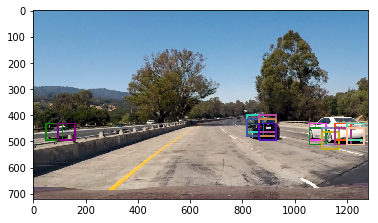

In [285]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, yrange, xrange, scale, model, cspace, orient, pix_per_cell, 
              cell_per_block, bin_size, draw = False):
    draw_img = np.copy(img)
    
    if cspace != None:
        img_inp = cv2.cvtColor(img[yrange[0]:yrange[1],xrange[0]:xrange[1],:], cspace).astype(np.float32)
    else:
        img_inp = img[yrange[0]: yrange[1], xrange[0]: xrange[1], :].astype(np.float32)
        
    if scale != 1:
        imshape = img_inp.shape
        img_inp = cv2.resize(img_inp, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    ch1, ch2, ch3 = img_inp[:, :, 0:1], img_inp[:, :, 1:2], img_inp[:, :, 2:3]
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_stepx = 3  # Instead of overlap, define how many cells to step
    cells_per_stepy = 1  # Instead of overlap, define how many cells to step

    nxsteps = (nxblocks - nblocks_per_window) // cells_per_stepx + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_stepy + 1
    
    if not draw:
        # Compute individual channel HOG features for the entire image
        hog1 = extract_hog_features(ch1, orient = orient,
                                        pix_per_cell = pix_per_cell, cell_per_block = cell_per_block, 
                                        feature_vec=False)[0][0]
        hog2 = extract_hog_features(ch2, orient = orient,
                                        pix_per_cell = pix_per_cell, cell_per_block = cell_per_block, 
                                        feature_vec=False)[0][0]
        hog3 = extract_hog_features(ch3, orient = orient,
                                        pix_per_cell = pix_per_cell, cell_per_block = cell_per_block, 
                                        feature_vec=False)[0][0]
    
    rects = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_stepy
            xpos = xb*cells_per_stepx
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            if not draw:
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
                
                window_img = cv2.resize(img_inp[ytop:ytop+window, xleft:xleft+window, :], (window, window))

                color_features = extract_color_features(window_img, size = bin_size).ravel()
                hist_features = extract_hist_features(window_img).ravel()
                
                features = np.hstack((color_features, hist_features, hog_features))
                test_prediction = model.predict([features])

            if draw or test_prediction[0] == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rects.append(((xbox_left + xrange[0], ytop_draw+yrange[0]),(xbox_left+win_draw+xrange[0],ytop_draw+win_draw+yrange[0])))
    draw_boxes(draw_img, rects)
    return draw_img, rects
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

def find_by_slide_window(img, yrange, xrange, scale, model, cspace, orient, pix_per_cell, 
              cell_per_block, bin_size, xy_overlap = (0.5, 0.5), draw = False):
    windows = slide_window(img, xrange, yrange, (64 * scale,) * 2, xy_overlap)
    if cspace != None:
        cvt_img = cv2.cvtColor(img, cspace)
    else:
        cvt_img = img
        
    res = []
    for window in windows:
        (xleft, ytop), (xright, ybot) = map(int, window[0]), map(int, window[1])
        subimg = cv2.resize(cvt_img[ytop: ybot, xleft: xright, :], (64, 64))
        hog_features = extract_hog_features(subimg, None, orient, pix_per_cell, cell_per_block)[0]
        color_features = extract_color_features(subimg, size = bin_size).ravel()
        hist_features = extract_hist_features(subimg).ravel()
        features = np.hstack((color_features, hist_features, hog_features))
        prediction = model.predict([features])
        if draw or prediction[0] == 1:
            res.append(((xleft, ytop), (xright, ybot)))
    draw_img = np.copy(img)
    draw_boxes(draw_img, res)
    return draw_img, res

    

scale = 1
yrange = (400, 400 + round(scale * 64 * 2))
orient = 15
pix_per_cell = 16
cell_per_block = 2
cspace = cv2.COLOR_BGR2YCrCb
bin_size = (16,) * 2

model = deserialize_model('YCrCb', orient, pix_per_cell, cell_per_block)

img = cv2.imread('test_images/test1.jpg')
out_img, rects = find_cars(img, yrange, (0, img.shape[1]), scale, model, cspace, orient, 
                           pix_per_cell, cell_per_block, bin_size)


rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
draw_boxes(rgb, rects, color = None)
plt.imshow(rgb)

# Different scale in windows to optimize for depth of field

In [354]:
def get_rects_from_window(img, orient, pix_per_cell, cell_per_block, cspace, bin_size,
                          model, scale = None, ystart = None, cropx = None, draw = False):
    yrange = (ystart, ystart + round(scale * 64 * 1.5))
    xrange = (int(img.shape[1] * cropx[0]), int(img.shape[1] * cropx[1]))
#     rects = find_cars(img, yrange, xrange, scale, model, cspace, orient, 
#                       pix_per_cell, cell_per_block, bin_size, draw = draw)[1]
    
    rects = find_by_slide_window(img, yrange, xrange, scale, model, cspace, orient, 
                  pix_per_cell, cell_per_block, bin_size, xy_overlap = (0.5, 0.75), draw = draw)[1]
    if draw:
        out_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        draw_boxes(out_img, rects, color = None)
        f = plt.figure(figsize = (8, 8))
        plt.imshow(out_img)
        f.gca().set_title('Scale {}, Y: {} - {}'.format(scale, yrange[0], yrange[1]))
    return rects

def search_with_windows(img, orient, pix_per_cell, cell_per_block, cspace, model, bin_size, draw = False):
    res = []
    
    rects = get_rects_from_window(img, orient, pix_per_cell, cell_per_block, cspace, bin_size, model,
                               scale = 1, ystart = 390, cropx = (0, 1), draw = draw)
    res.append(rects)

    rects = get_rects_from_window(img, orient, pix_per_cell, cell_per_block, cspace, bin_size, model,
                               scale = 1, ystart = 410, cropx = (0, 1), draw = draw)    
    res.append(rects)
    
    rects = get_rects_from_window(img, orient, pix_per_cell, cell_per_block, cspace, bin_size, model,
                               scale = 1, ystart = 430, cropx = (0, 1), draw = draw)
    res.append(rects)
        
    rects = get_rects_from_window(img, orient, pix_per_cell, cell_per_block, cspace, bin_size, model,
                               scale = 1.5, ystart = 390, cropx = (0, 1), draw = draw)
    res.append(rects)
    
    rects = get_rects_from_window(img, orient, pix_per_cell, cell_per_block, cspace, bin_size, model,
                               scale = 1.5, ystart = 410, cropx = (0, 1), draw = draw)
    res.append(rects)
    
    rects = get_rects_from_window(img, orient, pix_per_cell, cell_per_block, cspace, bin_size, model,
                               scale = 1.5, ystart = 430, cropx = (0, 1), draw = draw)
    res.append(rects)

    rects = get_rects_from_window(img, orient, pix_per_cell, cell_per_block, cspace, bin_size, model,
                               scale = 1.5, ystart = 420, cropx = (0, 1), draw = draw)
    res.append(rects)
    
    rects = get_rects_from_window(img, orient, pix_per_cell, cell_per_block, cspace, bin_size, model,
                               scale = 1.5, ystart = 450, cropx = (0, 1), draw = draw)
    res.append(rects)
    
    rects = get_rects_from_window(img, orient, pix_per_cell, cell_per_block, cspace, bin_size, model,
                               scale = 1.75, ystart = 450, cropx = (0, 1), draw = draw)
    res.append(rects)

#     rects = get_rects_from_window(img, orient, pix_per_cell, cell_per_block, cspace, bin_size, model,
#                                scale = 3, ystart = 440, cropx = (0, 1), draw = draw)
    res.append(rects)
        
    return res

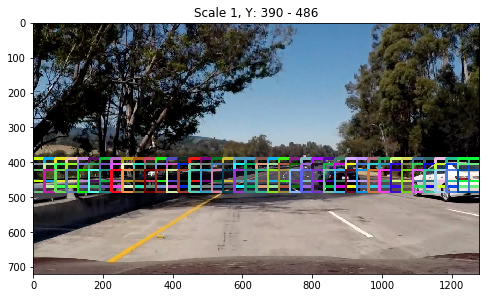

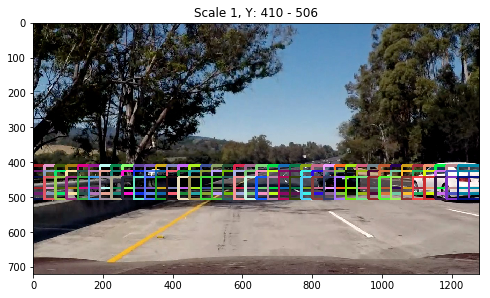

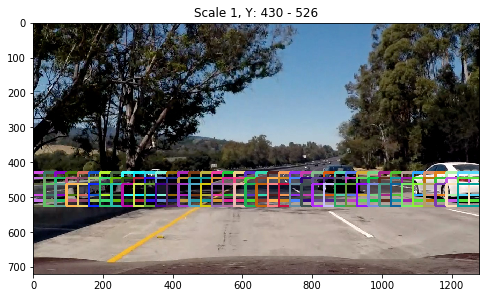

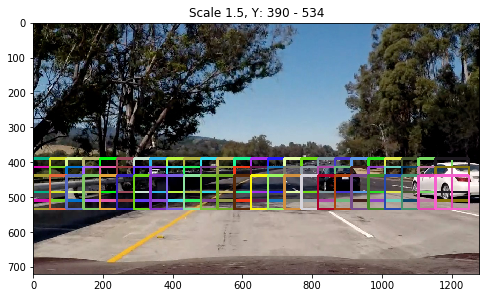

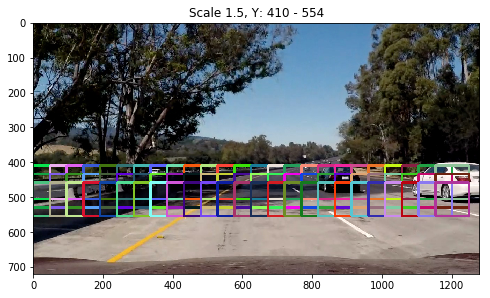

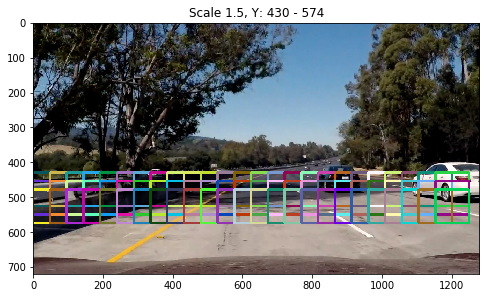

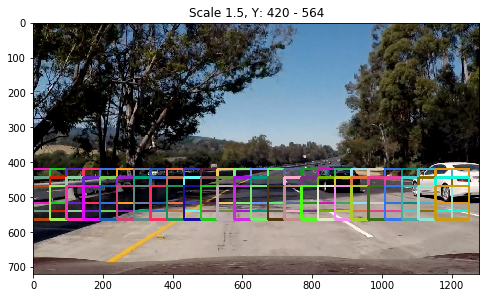

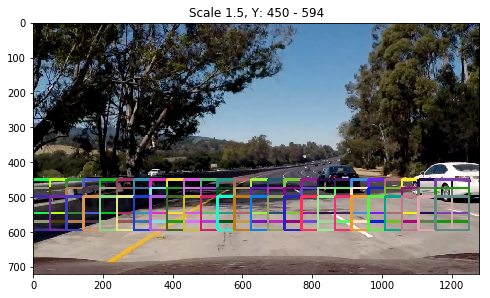

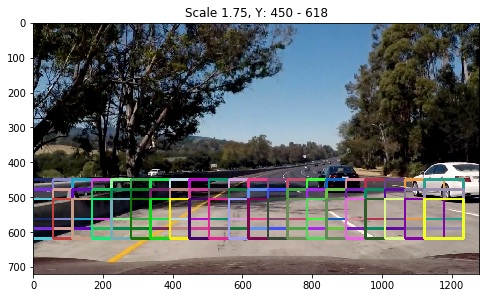

In [355]:
orient = 15
pix_per_cell = 16
cell_per_block = 2
bin_size = (32, ) * 2
cspace = cv2.COLOR_BGR2YCrCb
img = cv2.imread('test_images/test5.jpg')
model = deserialize_model('YCrCb', orient, pix_per_cell, cell_per_block)

boxes = search_with_windows(img, orient, pix_per_cell, cell_per_block, cspace, model, bin_size, draw = True)

# Make predictions with multiple window scales

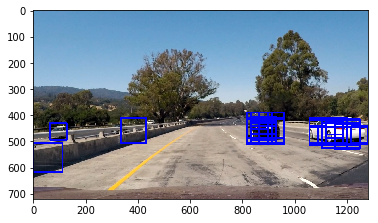

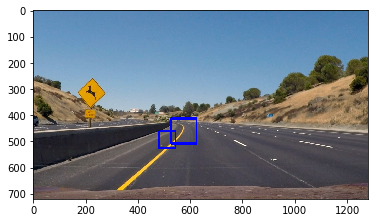

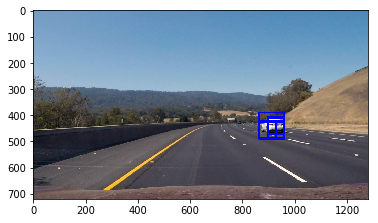

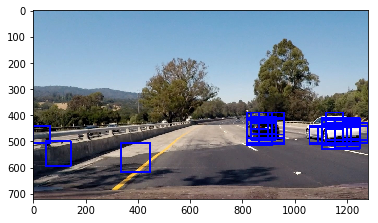

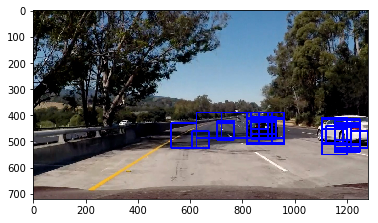

In [356]:
for t in range(1, 6):
    img = cv2.imread('test_images/test{}.jpg'.format(t))
    orient = 15
    pix_per_cell = 16
    cell_per_block = 2
    cspace = cv2.COLOR_BGR2YCrCb
    bin_size = (32,) * 2
    model = deserialize_model('YCrCb', orient, pix_per_cell, cell_per_block)

    windows = search_with_windows(img, orient, pix_per_cell, cell_per_block, cspace, model, bin_size, draw = False)
    boxes = [rect for window in windows for rect in window]

    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    draw_img = np.copy(rgb)
    draw_boxes(draw_img, boxes)
    f = plt.figure()
    plt.imshow(draw_img)

# Heat map functions to detect false positives

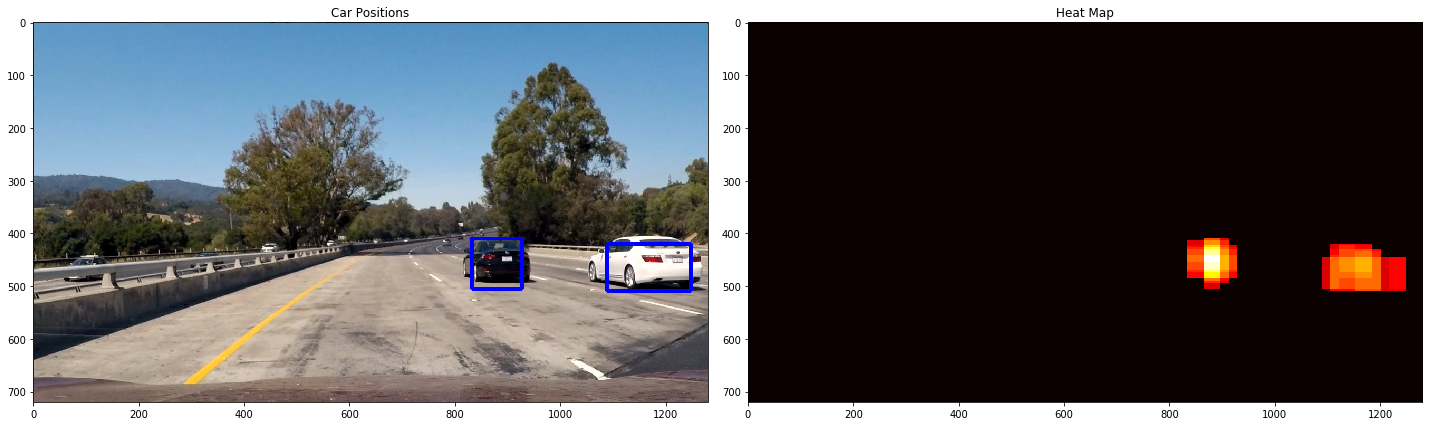

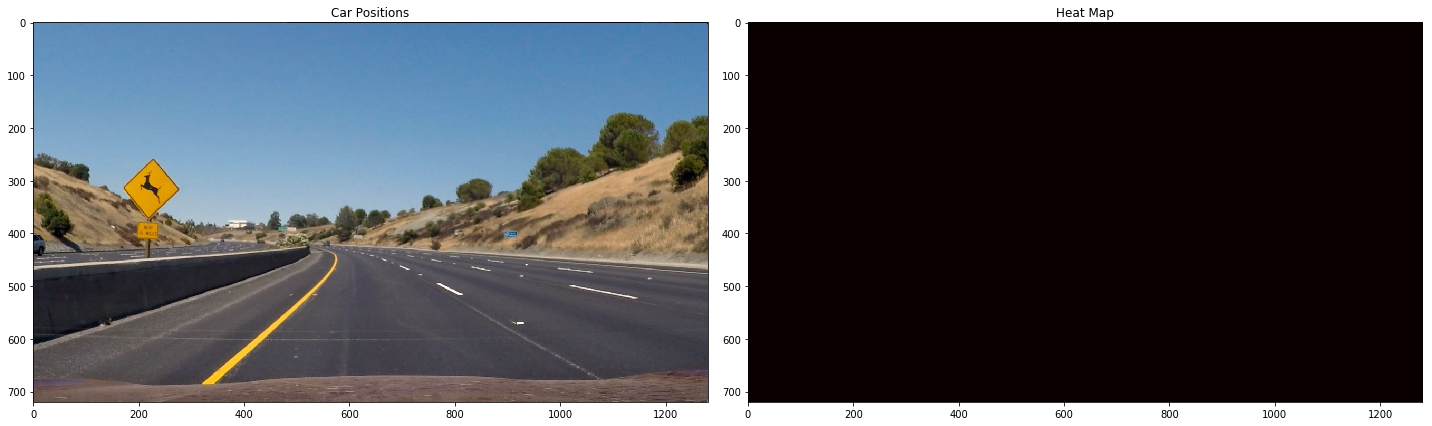

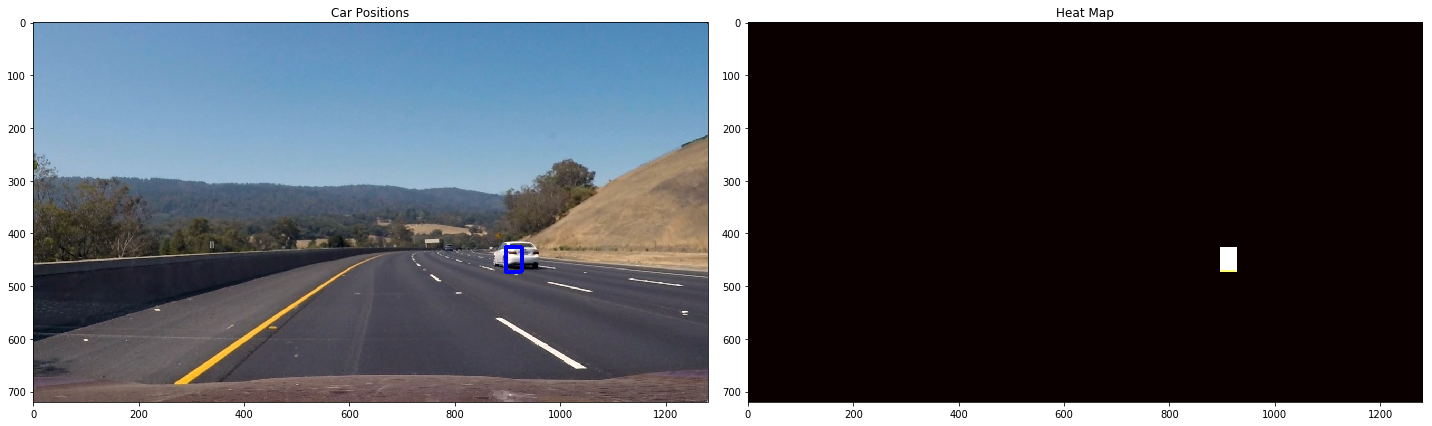

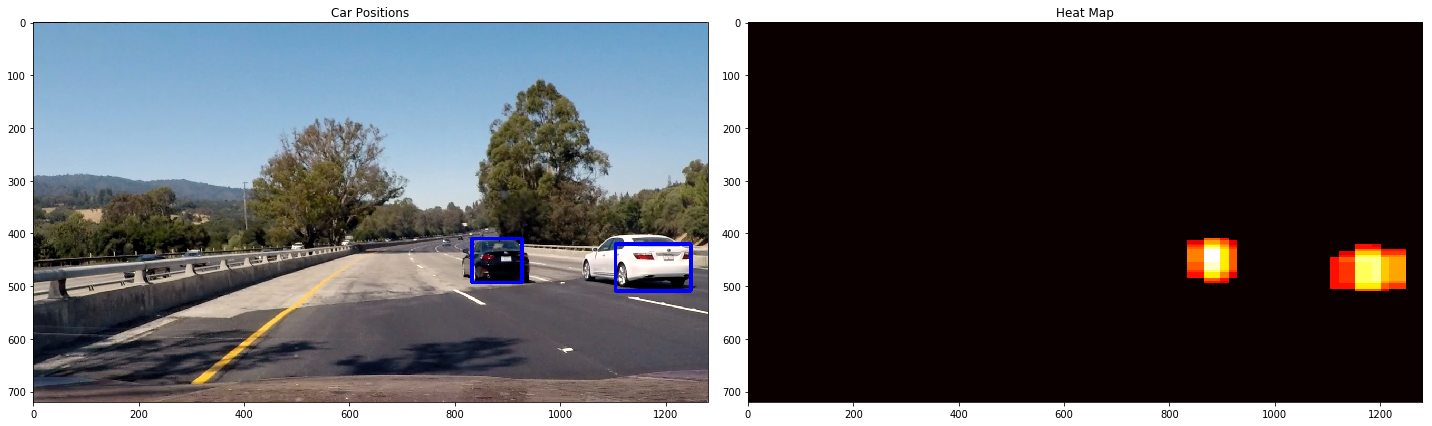

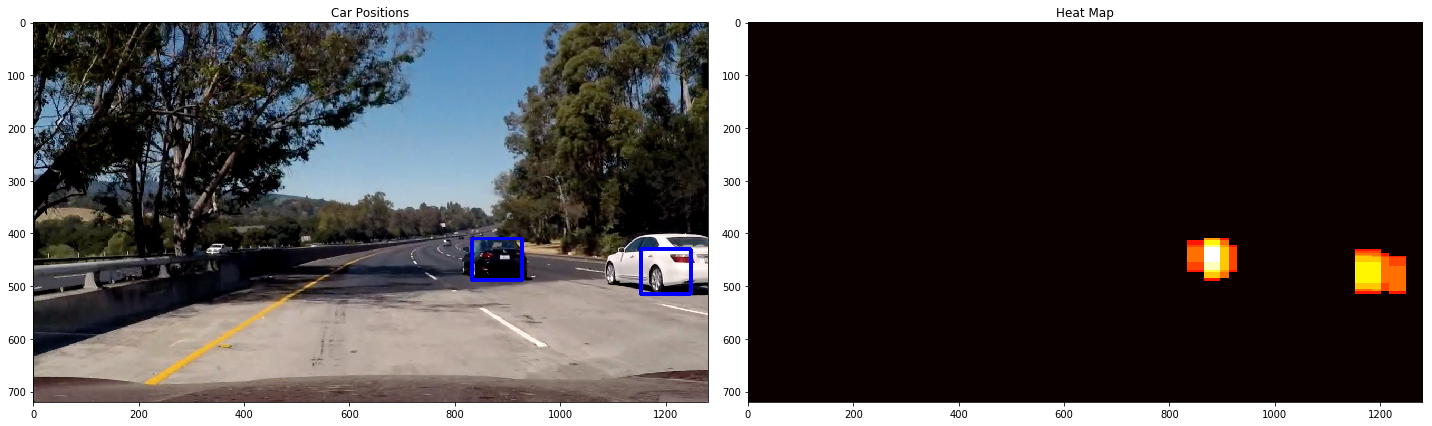

In [357]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

for t in range(1, 6):
    img = cv2.imread('test_images/test{}.jpg'.format(t))
    windows = search_with_windows(img, orient, pix_per_cell, cell_per_block, cspace, model, bin_size)
    boxes = [rect for window in windows for rect in window]
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    heat = np.zeros_like(img[:, :, 0])

    # Add heat to each box in box list
    heat = add_heat(heat, boxes)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 5)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = np.copy(rgb)
    draw_img = draw_labeled_bboxes(draw_img, labels)

    fig = plt.figure(figsize = (20, 10))
    plt.subplot(121)
    plt.imshow(draw_img)
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()

    # Pipeline to process video frame


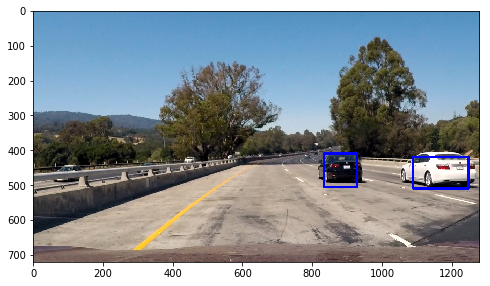

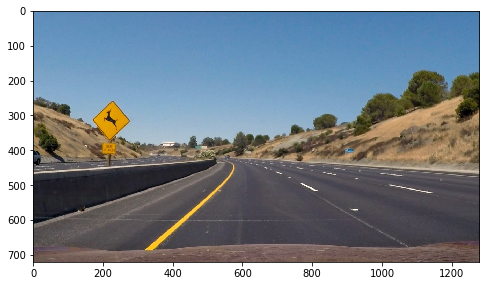

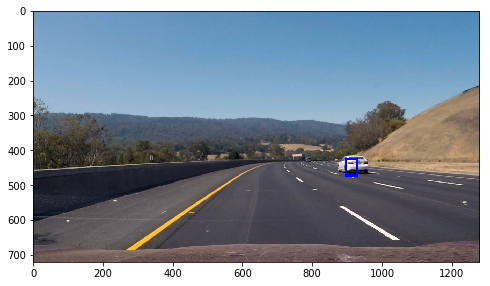

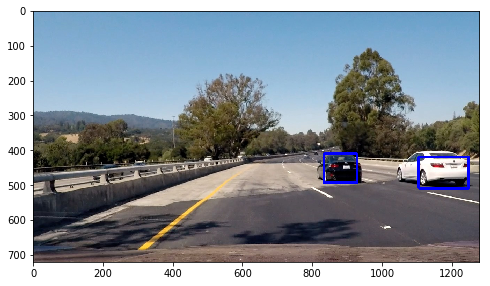

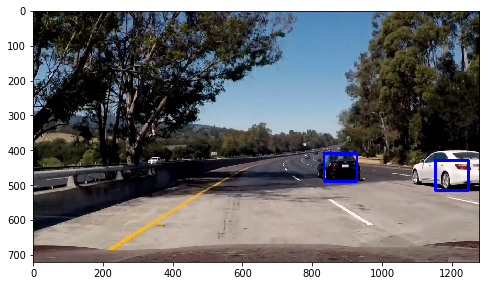

In [364]:
orient = 15
pix_per_cell = 16
cell_per_block = 2
cspace = cv2.COLOR_RGB2YCrCb
bin_size = (32, ) * 2

class DetectPipeline:
    def __init__(self, model, orient, pix_per_cell, cell_per_block, cspace, bin_size, n_frames = 10):
        self.model = model
        self.orient = orient
        self.pix_per_cell = pix_per_cell
        self.cell_per_block = cell_per_block
        self.cspace = cspace
        self.bin_size = bin_size
        self.n_frames = n_frames
        self.frames = []
        self.cnt = 0
        self.n_frame_per_sample = 7
        self.frame_hits = 0
        self.prev_labels = []

    def detect(self, img):
        if self.frame_hits % self.n_frame_per_sample != 0:
            self.frame_hits += 1
            draw_img = draw_labeled_bboxes(np.copy(img), self.prev_labels)

        else:
            windows = search_with_windows(img, 
                                          self.orient, self.pix_per_cell, self.cell_per_block, self.cspace, 
                                          self.model, self.bin_size)
            boxes = [rect for window in windows for rect in window]

            # Remember frame
            self.frames.append(boxes)

            # Remove frame when we have over self.n_frames
            if len(self.frames) > self.n_frames:
                self.frames = self.frames[1:]
            self.frame_hits = 0

            heat = np.zeros_like(img[:,:,0]).astype(np.float32)

            # Add heat to each box in box list
            for frame in self.frames:
                heat = add_heat(heat, frame)

            # Apply threshold to help remove false positives
            heatmap = apply_threshold(np.copy(heat), len(self.frames) + 4)
            # Find final boxes from heatmap using label function
            labels = label(heatmap)
            draw_img = draw_labeled_bboxes(np.copy(img), labels)

            self.prev_labels = labels
            
        
#         self.cnt += 1        
#         if self.cnt == 6:
#             full_draw = np.copy(img)
#             draw_boxes(full_draw, boxes)
#             f = plt.figure(figsize = (20, 10))
#             plt.imshow(full_draw)
            
#             z_heat = np.zeros_like(img[:, :, 0].astype(np.float))
#             frame_heats = [add_heat(np.copy(z_heat), frame) for frame in self.frames]
#             f = plt.figure(figsize = (20, 5))
#             grid = (1, 6)
#             coors = np.vstack(np.mgrid[:grid[0], :grid[1]].T)
#             for idx, frame_heat in enumerate(frame_heats):
#                 axis = plt.subplot2grid(grid, coors[idx])
#                 axis.imshow(frame_heat, cmap = 'hot')
#             f = plt.figure(figsize = (20, 10))
#             plt.imshow(heat, cmap = 'hot')
            
#             f = plt.figure(figsize = (20, 10))
#             plt.imshow(draw_img)
            
        return draw_img
    
    def reset():
        self.frames = []
    
model = deserialize_model('YCrCb', orient, pix_per_cell, cell_per_block)
n_frames = 10

for t in range(1, 6):
    pipeline = DetectPipeline(model, orient, pix_per_cell, cell_per_block, cspace, bin_size, n_frames)
    img = cv2.imread('test_images/test{}.jpg'.format(t))[:, :, ::-1]
    f = plt.figure(figsize = (8, 8))
    plt.imshow(pipeline.detect(img))

# Process Video

In [365]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

orient = 15
pix_per_cell = 16
cell_per_block = 2
cspace = cv2.COLOR_RGB2YCrCb
bin_size = (32, ) * 2
model = deserialize_model('YCrCb', orient, pix_per_cell, cell_per_block)
n_frames = 10

pipeline = DetectPipeline(model, orient, pix_per_cell, cell_per_block, cspace, bin_size, n_frames)

out = 'test_video_out.mp4'
clip = VideoFileClip('test_video.mp4')
clip_out = clip.fl_image(pipeline.detect)
%time clip_out.write_videofile(out, audio=False)

OSError: [Errno 12] Cannot allocate memory

In [330]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(out))

In [338]:
orient = 12
pix_per_cell = 8
cell_per_block = 2
cspace = cv2.COLOR_RGB2YCrCb
bin_size = (32 ,) * 2
model = deserialize_model('YCrCb', orient, pix_per_cell, cell_per_block)
n_frames = 10

pipeline = DetectPipeline(model, orient, pix_per_cell, cell_per_block, cspace, bin_size, n_frames)

out = 'project_video_out.mp4'
clip = VideoFileClip('project_video.mp4').subclip(2, 3)
clip_out = clip.fl_image(pipeline.detect)
%time clip_out.write_videofile(out, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4



 96%|█████████▌| 25/26 [01:30<00:03,  3.45s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 1min 43s, sys: 228 ms, total: 1min 43s
Wall time: 1min 32s


In [340]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(out))